In [2]:
%%time

import os, psutil
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_validate,cross_val_score,train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score
from sklearn import ensemble,metrics,model_selection,neighbors,preprocessing, svm, tree
import lightgbm as lgb
from lightgbm import LGBMClassifier

from statsmodels.graphics.mosaicplot import mosaic

# machine learning tools
import h2o
from h2o.estimators import H2OGeneralizedLinearEstimator, H2ORandomForestEstimator, H2OGradientBoostingEstimator

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

CPU times: total: 1.52 s
Wall time: 2.13 s


In [3]:
%%time
# taken from https://www.kaggle.com/ryanholbrook/getting-started-september-2021-tabular-playground

def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

def score(X, y, model, cv):
    scoring = ["roc_auc"]
    scores = cross_validate(
        model, X_train, y_train, scoring=scoring, cv=cv, return_train_score=True
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )
print('Function built')

Function built
CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
%%time
# Get data
train=pd.read_csv('train_final.csv')
test=pd.read_csv('test_final.csv')
print("Data imported")

## from: https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

train = reduce_memory_usage(train, verbose=True)
test = reduce_memory_usage(test, verbose=True)
print(cpu_stats())
print('Memory reduced')

Data imported
Mem. usage decreased to 0.25 Mb (86.8% reduction)
Mem. usage decreased to 0.33 Mb (86.8% reduction)
memory GB:0.25
Memory reduced
CPU times: total: 109 ms
Wall time: 143 ms


features obtained


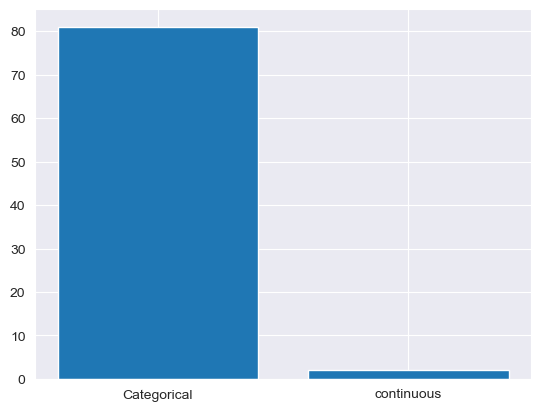

CPU times: total: 109 ms
Wall time: 127 ms


In [5]:
%%time
features=[]
cat_features=[]
cont_features=[]
for feature in test.columns:
    features.append(feature)
    if test.dtypes[feature]=='int8':
        cat_features.append(feature)
    if test.dtypes[feature]=='float16':
        cont_features.append(feature)
    #print(test.dtypes[feature])
print('features obtained')

plt.bar([1,2],[len(cat_features),len(cont_features)])
plt.xticks([1,2],('Categorical','continuous'))
plt.show()

In [6]:
%%time
# Get shape of data
print('*'*40, '\nHow much data was imported?')
print('*'*40)
print('Training data :', train.shape)
print('Test data :', test.shape)
print('*'*40,"\n")

# missing data
print('*'*40,'\nHow much data is missing?')
print('*'*40)
training_missing_val_count_by_column = (train.isnull().values.sum())
test_missing_val_count_by_column = (test.isnull().values.sum())
print('Missing training data :  {:.2f} ({:.1f})%'.format (training_missing_val_count_by_column,training_missing_val_count_by_column/train.shape[0]))
print('Missing test data :  {:.2f} ({:.1f})%'.format (test_missing_val_count_by_column,test_missing_val_count_by_column/test.shape[0]))
print('*'*40,"\n")

# categorical data
print('*'*40,'\nFeature types?')
print('*'*40)
print('Categorical features : ', (len(cat_features)))
print('Continuous features : ', (len(cont_features)))
print('*'*40,'\n')

# get info
print('*'*40,'\nInfo on datasets')
print('*'*40)
print(train.info(),'\n')
print(test.info(),'\n')
print('*'*40)

print('\noverview complete')
del training_missing_val_count_by_column,test_missing_val_count_by_column

**************************************** 
How much data was imported?
****************************************
Training data : (2853, 87)
Test data : (3854, 86)
**************************************** 

**************************************** 
How much data is missing?
****************************************
Missing training data :  0.00 (0.0)%
Missing test data :  0.00 (0.0)%
**************************************** 

**************************************** 
Feature types?
****************************************
Categorical features :  81
Continuous features :  2
**************************************** 

**************************************** 
Info on datasets
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2853 entries, 0 to 2852
Data columns (total 87 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      2853 non-null   int16  
 1   Y       2853 non-null   int8   
 2   2       2853 non-null

In [7]:
%%time
# Get column titles
#print('*'*40,'\nColumn Names')
#print('*'*40)
#print(features)
#print('*'*40)

# Get sample data
print('*'*40,'\nSample Training Data')
print('*'*40)
print(train.head(),'\n')
#print('*'*40,'\n')
#print('*'*40,'\nSample Test Data')
#print('*'*40)

**************************************** 
Sample Training Data
****************************************
   Id  Y  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  \
0   1  0  0  0  0  1  0  0  0  0   0   0   0   0   0   0   0   0   0   1   1   
1   2  1  0  0  0  1  0  0  0  0   0   0   0   0   1   0   0   0   0   1   0   
2   3  1  0  0  0  1  0  0  0  1   1   0   0   0   1   0   0   1   0   0   0   
3   4  0  0  1  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   1   1   
4   5  0  0  0  0  0  0  0  0  0   0   0   0   1   0   0   0   0   0   1   1   

   21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  \
0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   
2   1   1   0   0   1   0   1   0   1   0   0   1   0   0   0   0   0   0   0   
3   0   1   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   
4   0   0 

In [8]:
%%time
# Get column titles
#print('*'*40,'\nColumn Names')
#print('*'*40)
#print(features)
#print('*'*40)

# Get sample data
print('*'*40,'\nSample Test Data')
print('*'*40)
print(test.head(),'\n')
#print('*'*40,'\n')
#print('*'*40,'\nSample Test Data')
#print('*'*40)

**************************************** 
Sample Test Data
****************************************
     Id  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  \
0  2854  0  0  0  1  0  0  0  0   0   0   0   1   0   0   0   0   0   0   1   
1  2855  0  0  0  1  0  0  0  0   0   0   0   1   1   0   0   0   0   1   0   
2  2856  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   1   1   
3  2857  0  0  0  1  1  0  0  0   0   1   0   0   0   0   1   0   0   1   1   
4  2858  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   1   0   

   21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  \
0   1   1   0   0   0   0   1   0   0   0   0   1   0   0   0   0   0   0   0   
1   0   1   0   0   0   0   1   0   0   0   0   1   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   
3   1   1   0   0   0   0   1   1   0   0   0   1   0   0   0   1   0   0   0   
4   0   1   0   0   

Already separated
Training data (blue), Test Data (red)


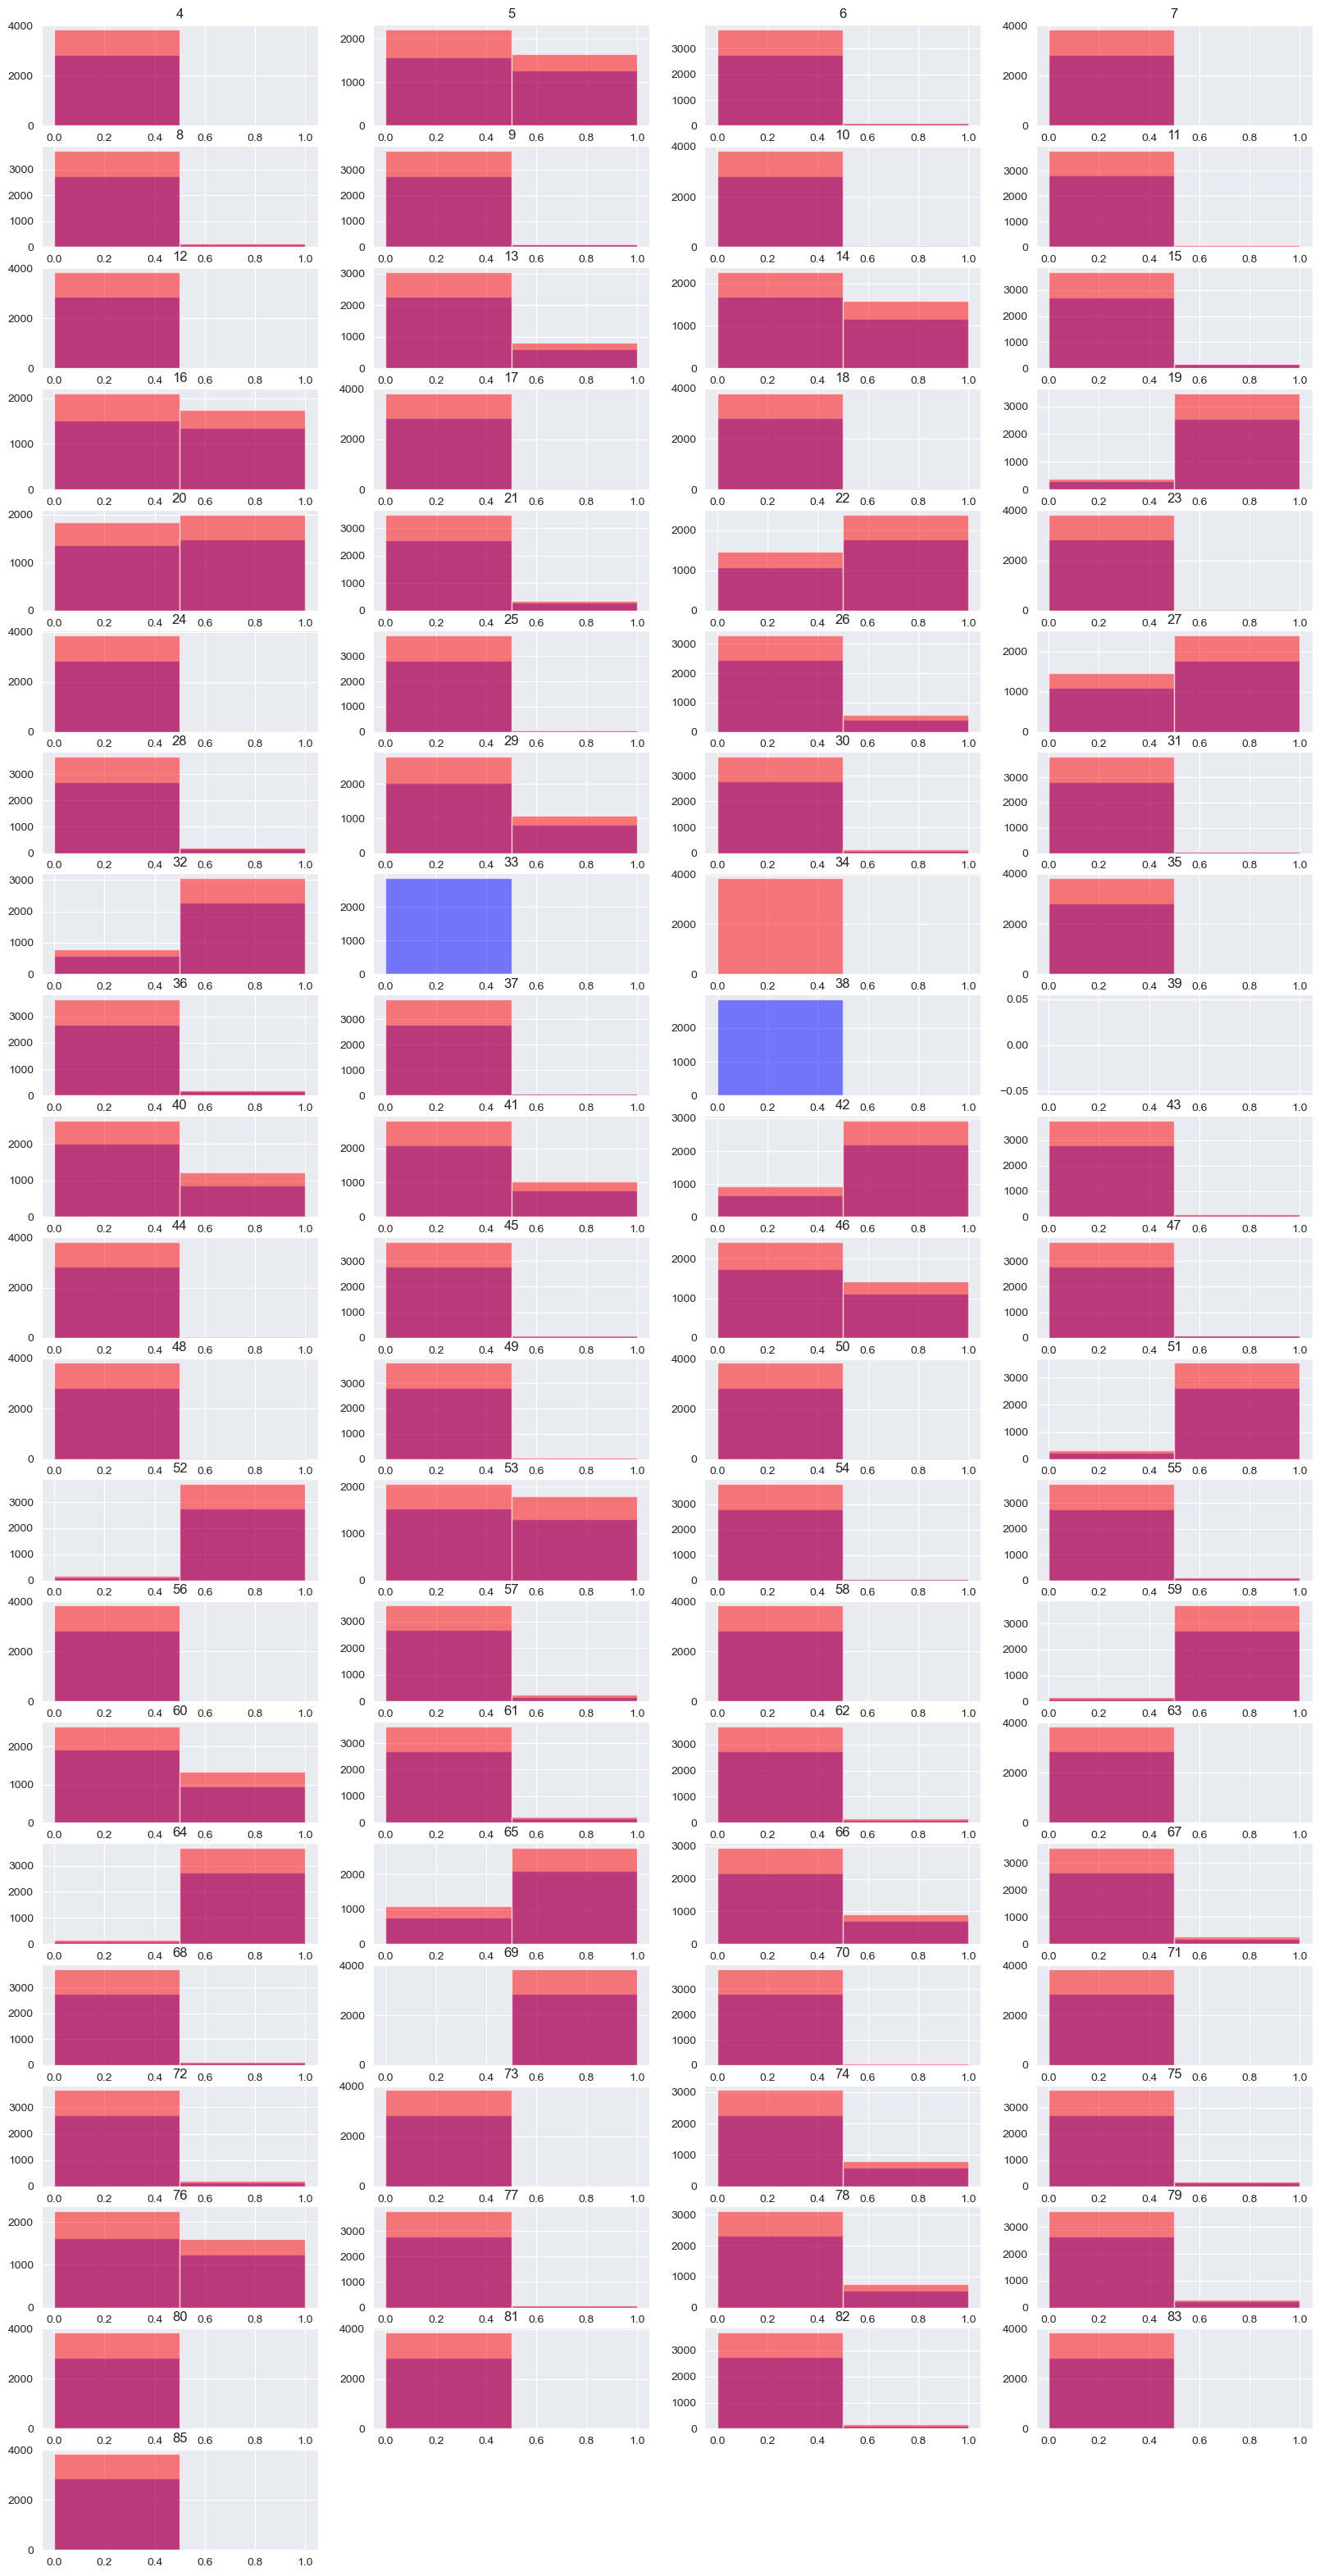

CPU times: total: 9.84 s
Wall time: 10 s


In [9]:
%%time
train_outliers = ((train[cat_features] - train[cat_features] .min())/(train[cat_features] .max() - train[cat_features] .min()))
test_outliers = ((test[cat_features] - test[cat_features].min())/(test[cat_features].max() - test[cat_features].min()))
try:
    train_outliers.drop(['claim'], axis=1, inplace=True)
except:
    print('Already separated')
print('Training data (blue), Test Data (red)')
fig = plt.figure(figsize = (20, 40))
for idx, i in enumerate(train_outliers.columns):
    fig.add_subplot(int(np.ceil(len(train_outliers.columns)/4)), 4, idx+1)
    train_outliers.iloc[:, idx].hist(bins = 2,color='b',alpha=0.5)
    test_outliers.iloc[:, idx].hist(bins = 2,color='r',alpha=0.5)
    plt.title(i)
#plt.text(9, -20000, caption, size = 12)
plt.show()
del train_outliers, test_outliers

Already separated
Already separated
Distribution for category features, red=target 0, blue=target 1


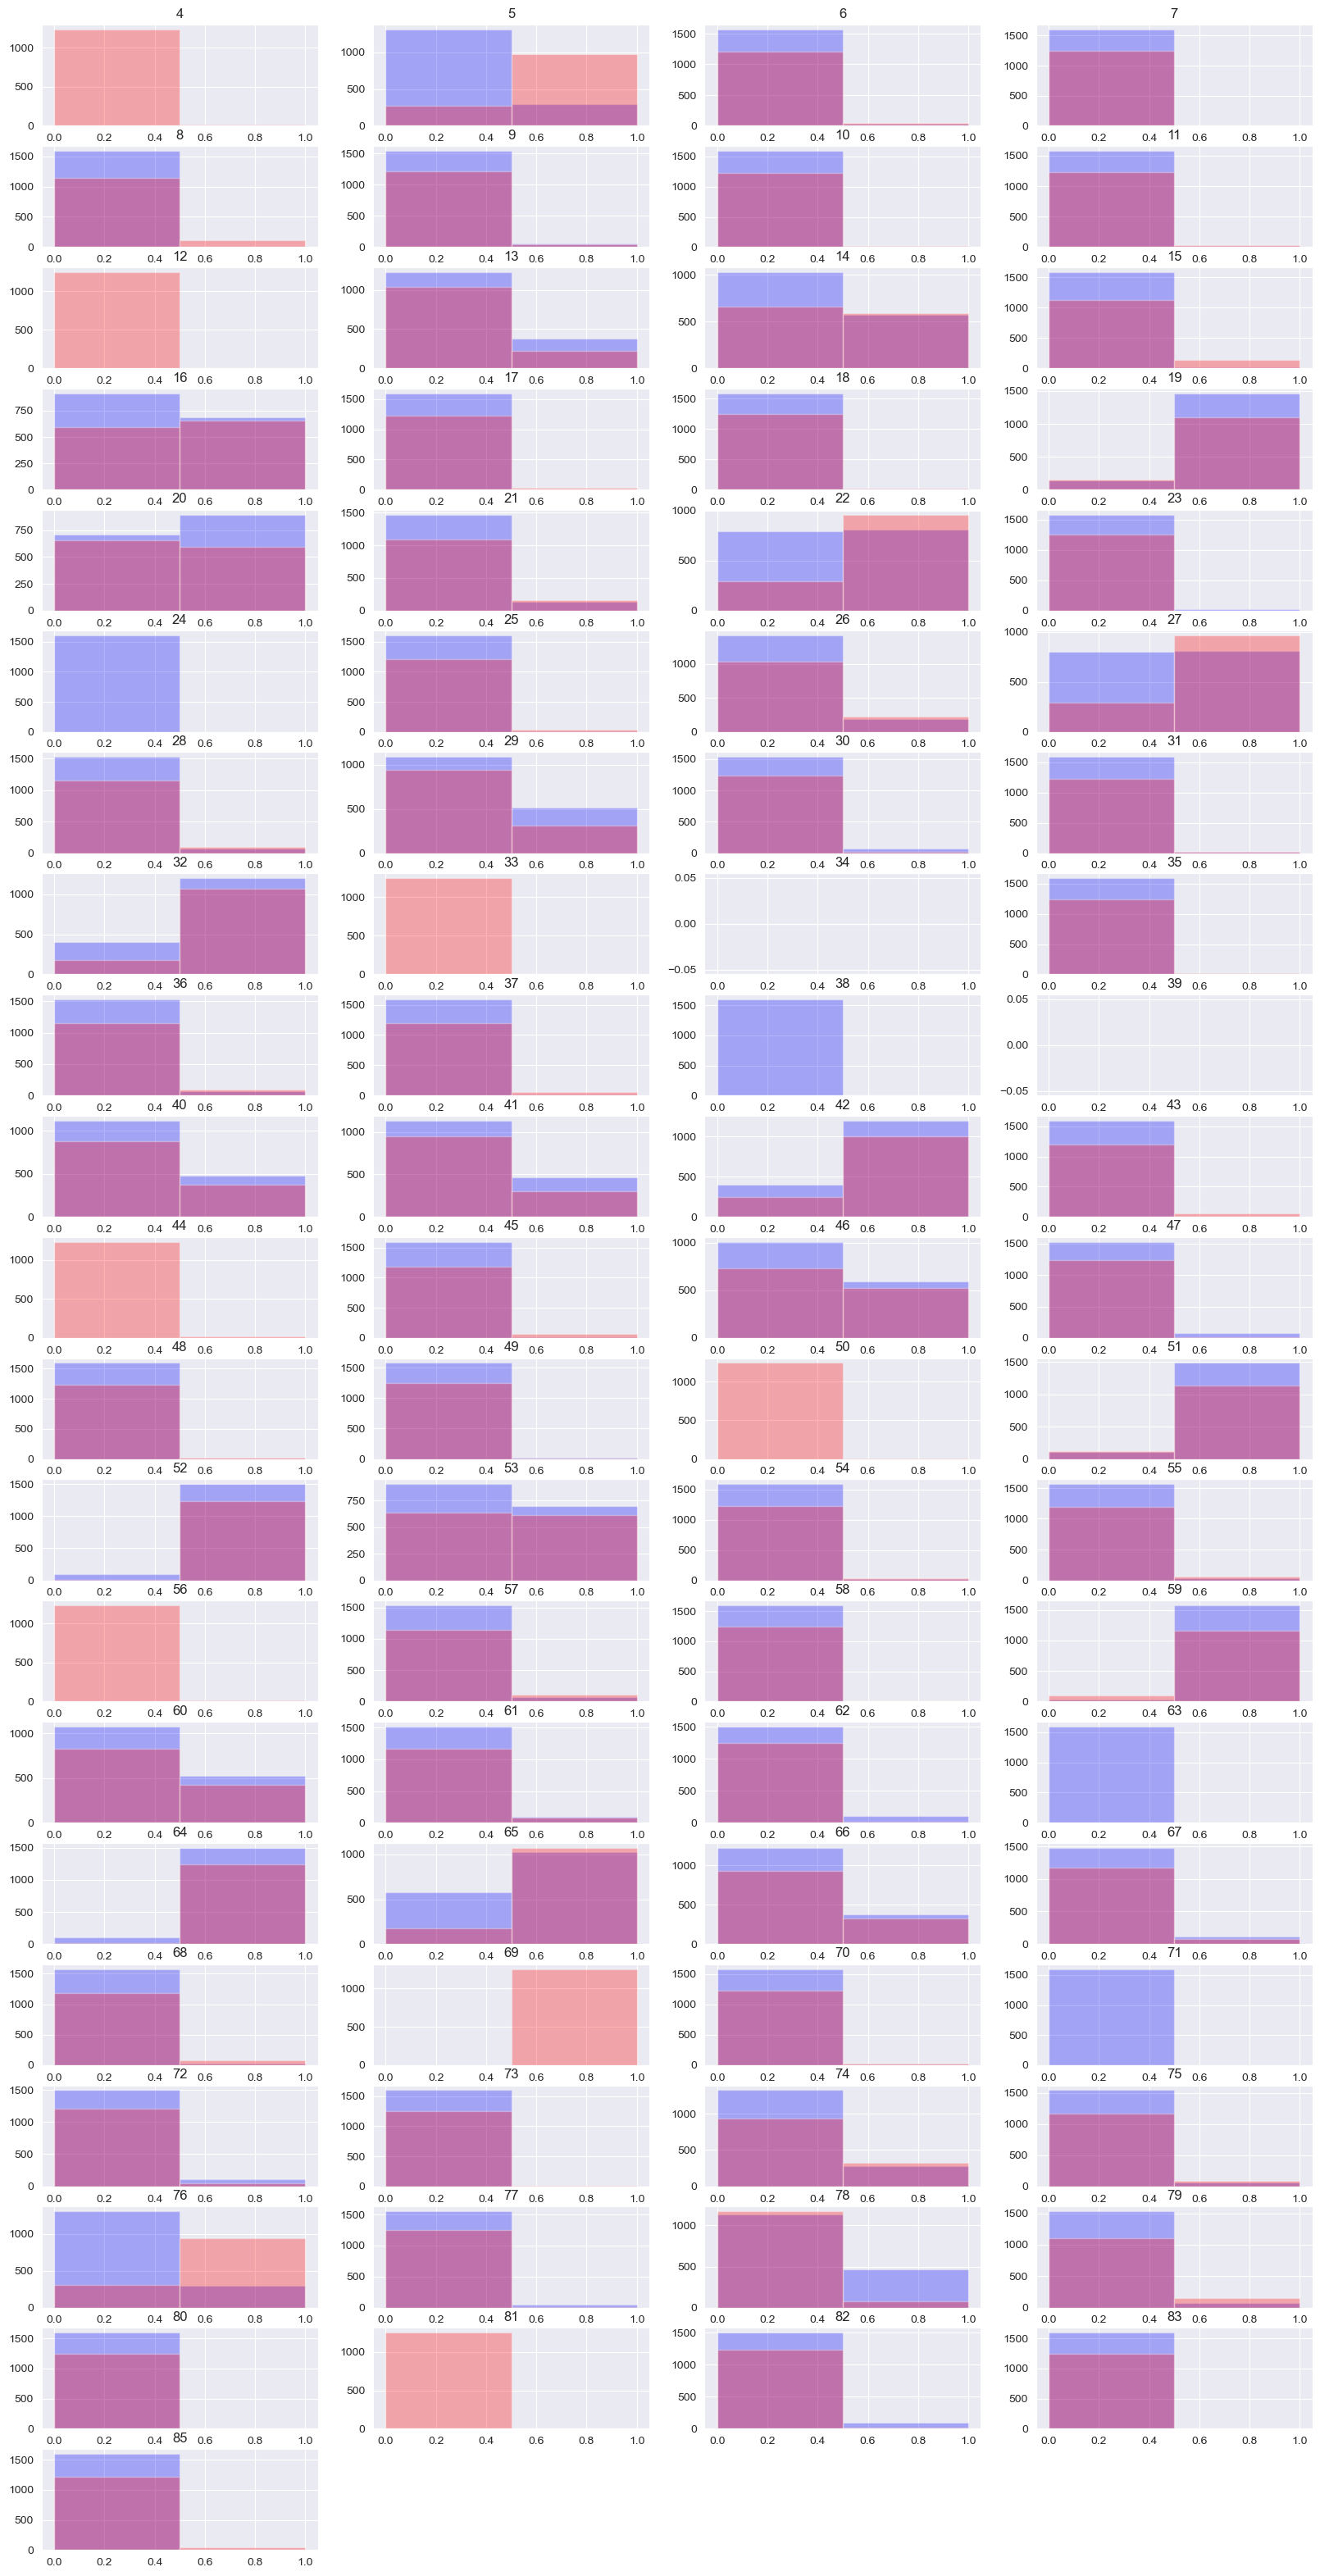

CPU times: total: 10.2 s
Wall time: 10.3 s


In [10]:
%%time
# category features by target value

# separate data by target value
train_0=train[train.Y==0]
train_1=train[train.Y==1]

# separate cat features
train_outliers = ((train[cat_features] - train[cat_features] .min())/(train[cat_features] .max() - train[cat_features] .min()))
train_outliers_0 = ((train_0[cat_features] - train_0[cat_features] .min())/(train_0[cat_features] .max() - train_0[cat_features] .min()))
train_outliers_1 = ((train_1[cat_features] - train_1[cat_features].min())/(train_1[cat_features].max() - train_1[cat_features].min()))
try:
    train_outliers_0.drop(['claim'], axis=1, inplace=True)
except:
    print('Already separated')
try:
    train_outliers_1.drop(['claim'], axis=1, inplace=True)
except:
    print('Already separated')
print('Distribution for category features, red=target 0, blue=target 1')
fig = plt.figure(figsize = (20, 40))
for idx, i in enumerate(train_outliers_0.columns):
    fig.add_subplot(int(np.ceil(len(train_outliers_0.columns)/4)), 4, idx+1)
    train_outliers_0.iloc[:, idx].hist(bins = 2,color='b',alpha=0.3)
    train_outliers_1.iloc[:, idx].hist(bins = 2,color='r',alpha=0.3)
    plt.title(i)
plt.show()
del train_outliers_0, train_outliers_1,train_0, train_1

Already separated
Training data (blue), Test Data (red)


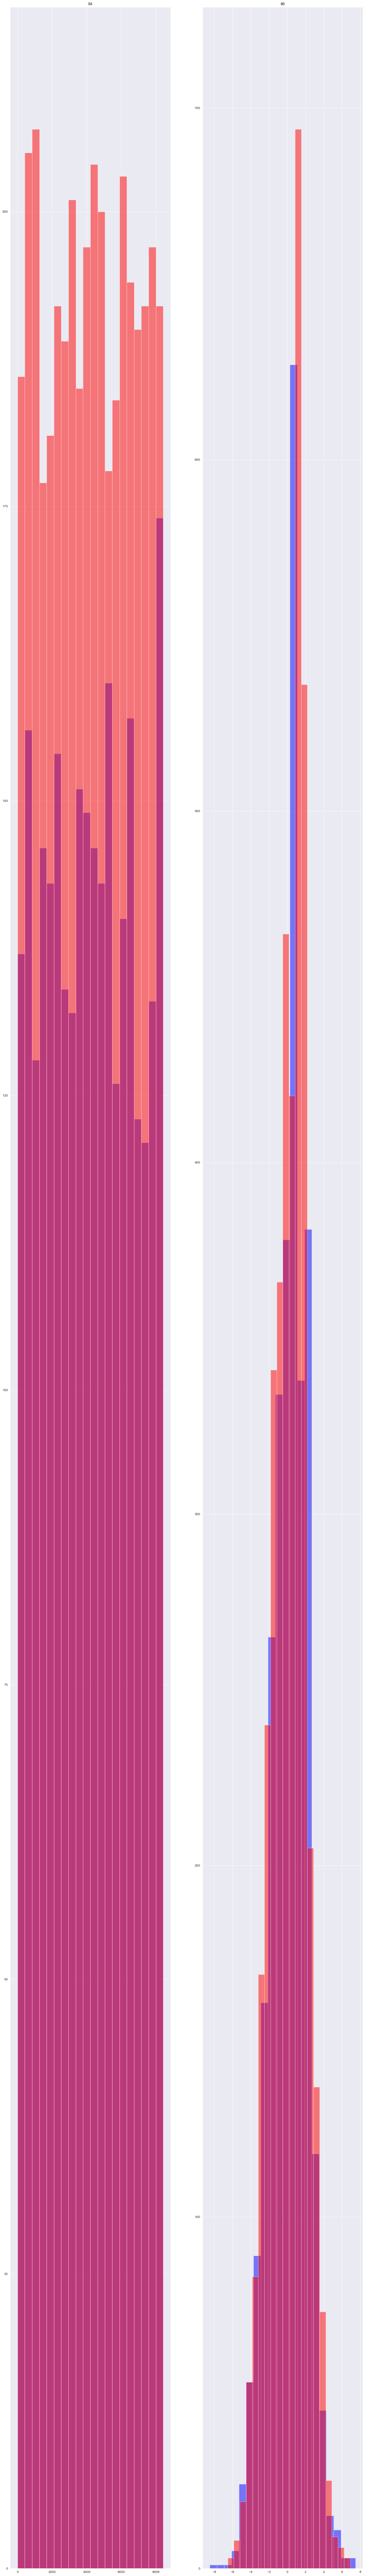

CPU times: total: 1.16 s
Wall time: 1.16 s


In [11]:
%%time
#train_outliers = ((train[cont_features] - train[cont_features].min())/(train[cont_features].max() - train[cont_features].min()))
#train_test = ((test[cont_features] - test[cont_features].min())/(test[cont_features].max() - test[cont_features].min()))
train_outliers=train[cont_features]
test_outliers=test[cont_features]
try:
    train_outliers.drop(['claim'], axis=1, inplace=True)
except:
    print('Already separated')
print('Training data (blue), Test Data (red)')
fig = plt.figure(figsize = (40, 140))
for idx, i in enumerate(train_outliers.columns):
    fig.add_subplot(int(np.ceil(len(train_outliers.columns)/4)), 4, idx+1)
    train_outliers.iloc[:, idx].hist(bins=20,color='b',alpha=0.5)
    test_outliers.iloc[:, idx].hist(bins = 20,color='r',alpha=0.5)
    plt.subplots_adjust(hspace=0.2)
    plt.title(i)
plt.show()

Already separated
Already separated
Distribution of continuous features, red=target0, blue=target1


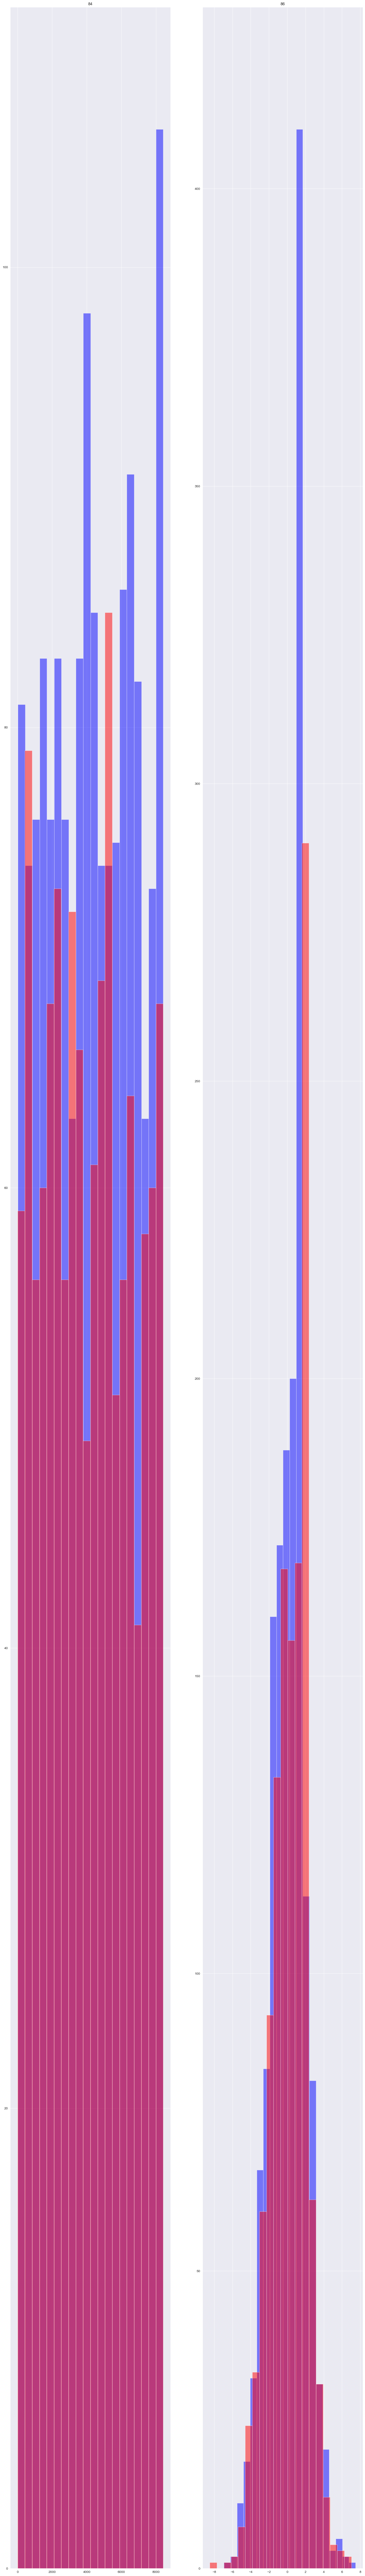

CPU times: total: 1.08 s
Wall time: 1.08 s


In [12]:
%%time
# continuous features by target value

# separate data by target value
train_0=train[train.Y==0]
train_1=train[train.Y==1]

train_outliers_0=train_0[cont_features]
train_outliers_1=train_1[cont_features]
try:
    train_outliers_0.drop(['claim'], axis=1, inplace=True)
except:
    print('Already separated')
try:
    train_outliers_1.drop(['claim'], axis=1, inplace=True)
except:
    print('Already separated')
print('Distribution of continuous features, red=target0, blue=target1')
fig = plt.figure(figsize = (40, 140))
for idx, i in enumerate(train_outliers_0.columns):
    fig.add_subplot(int(np.ceil(len(train_outliers_0.columns)/4)), 4, idx+1)
    train_outliers_0.iloc[:, idx].hist(bins=20,color='b',alpha=0.5)
    train_outliers_1.iloc[:, idx].hist(bins = 20,color='r',alpha=0.5)
    plt.subplots_adjust(hspace=0.2)
    plt.title(i)
plt.show()

ValueError: min() arg is an empty sequence

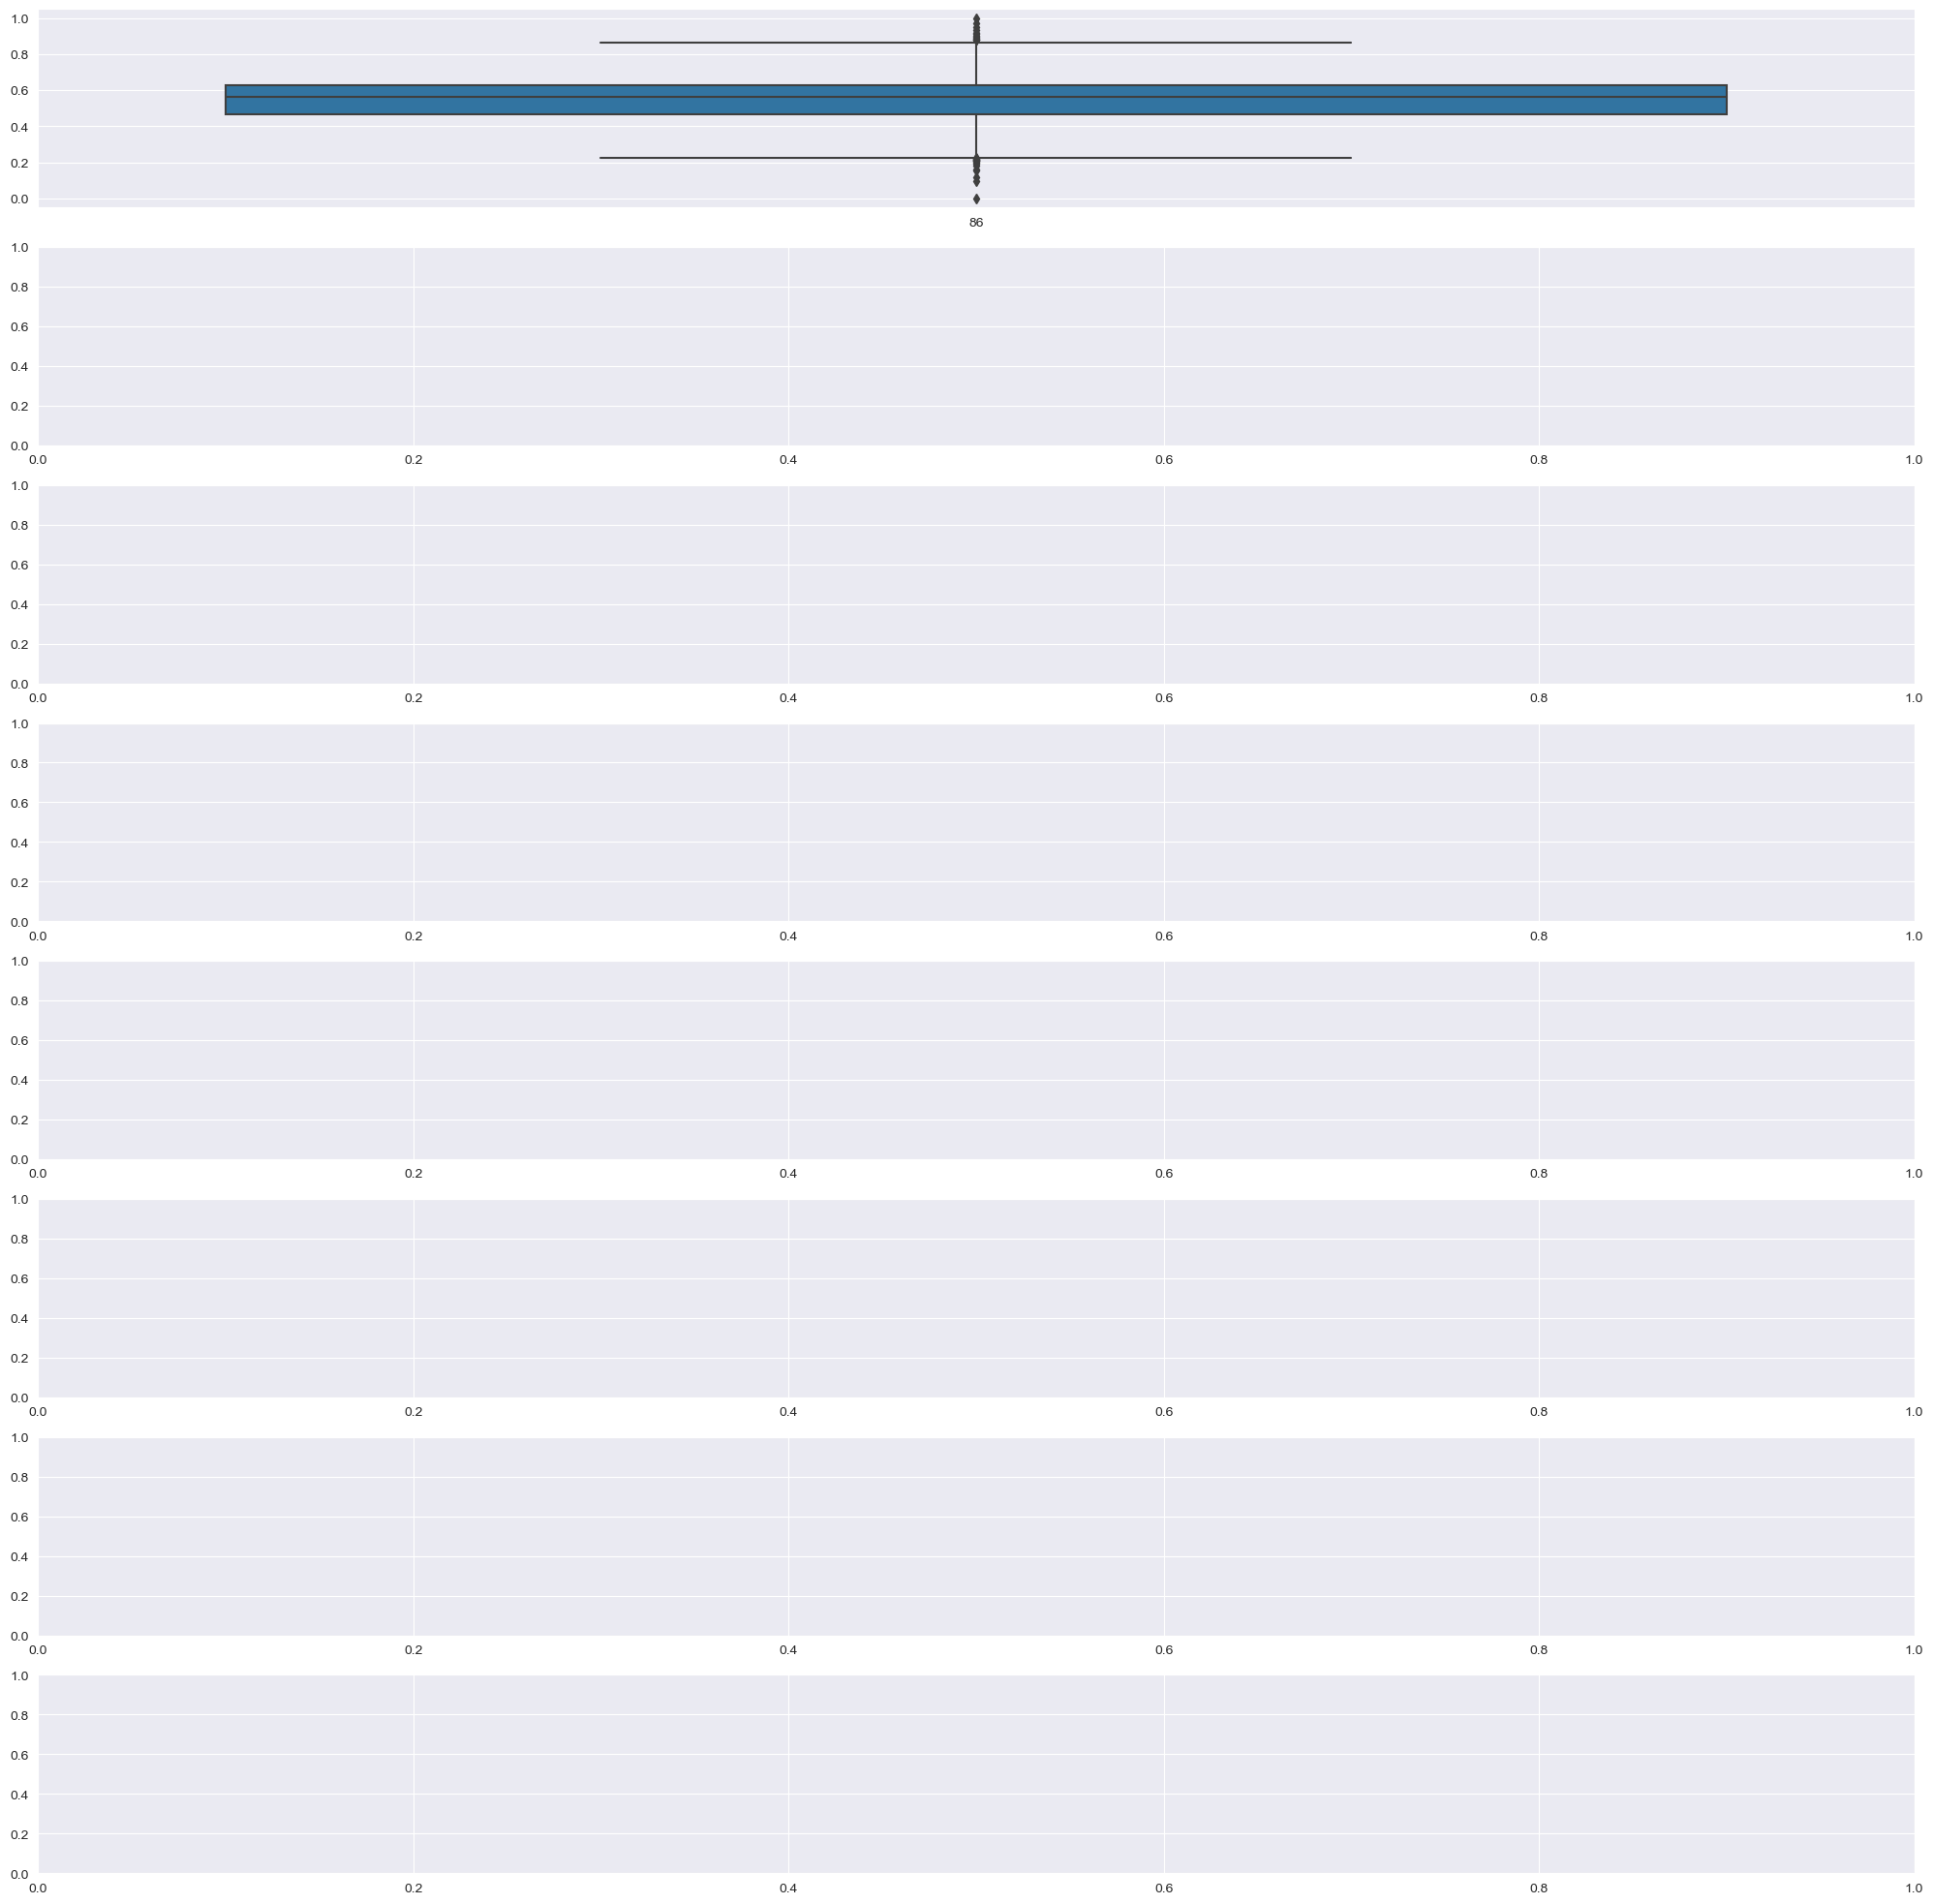

In [13]:
%%time
# generate box plots
train_outliers = ((train[cont_features] - train[cont_features].min())/(train[cont_features].max() - train[cont_features].min()))
fig, ax = plt.subplots(8, 1, figsize = (25,25))
sns.boxplot(data = train_outliers.iloc[:, 1:30], ax = ax[0])
sns.boxplot(data = train_outliers.iloc[:, 30:60], ax = ax[1])
sns.boxplot(data = train_outliers.iloc[:, 60:90], ax = ax[2])
sns.boxplot(data = train_outliers.iloc[:, 90:120], ax = ax[3])
sns.boxplot(data = train_outliers.iloc[:, 120:150], ax = ax[4])
sns.boxplot(data = train_outliers.iloc[:, 150:180], ax = ax[5])
sns.boxplot(data = train_outliers.iloc[:, 180:210], ax = ax[6])
sns.boxplot(data = train_outliers.iloc[:, 210:240], ax = ax[7])
plt.show()
del train_outliers

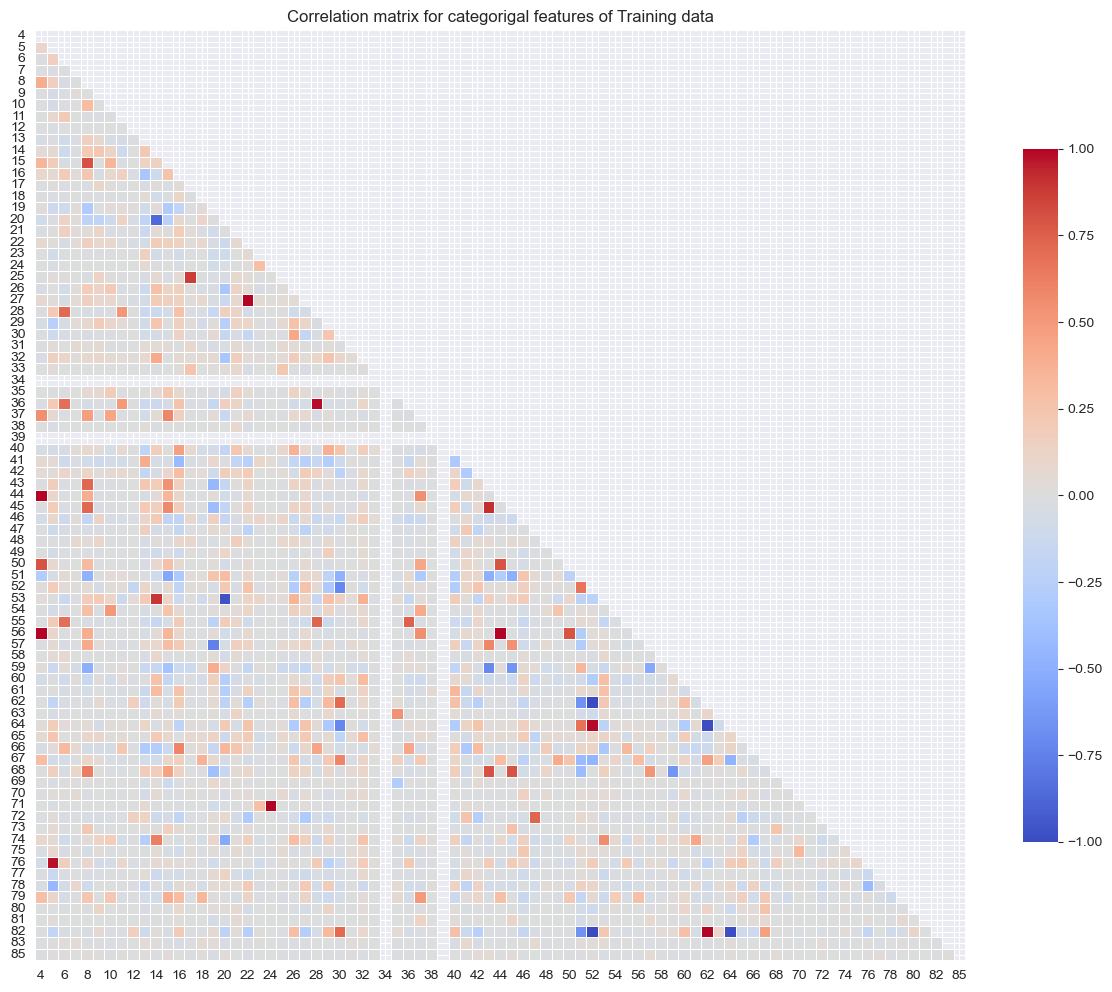

CPU times: total: 906 ms
Wall time: 907 ms


In [14]:
%%time
# Generate correlations in categorical data
corr=train[cat_features].corr()

# create heatmap
mask = np.triu(np.ones_like(corr, dtype = bool))
plt.figure(figsize = (15, 15))
plt.title('Correlation matrix for categorigal features of Training data')
sns.heatmap(corr,cmap='coolwarm', mask = mask,annot=False, linewidths = .5,square=True,cbar_kws={"shrink": .60})
plt.show()

initial correlations calculated
highest correlations calculated


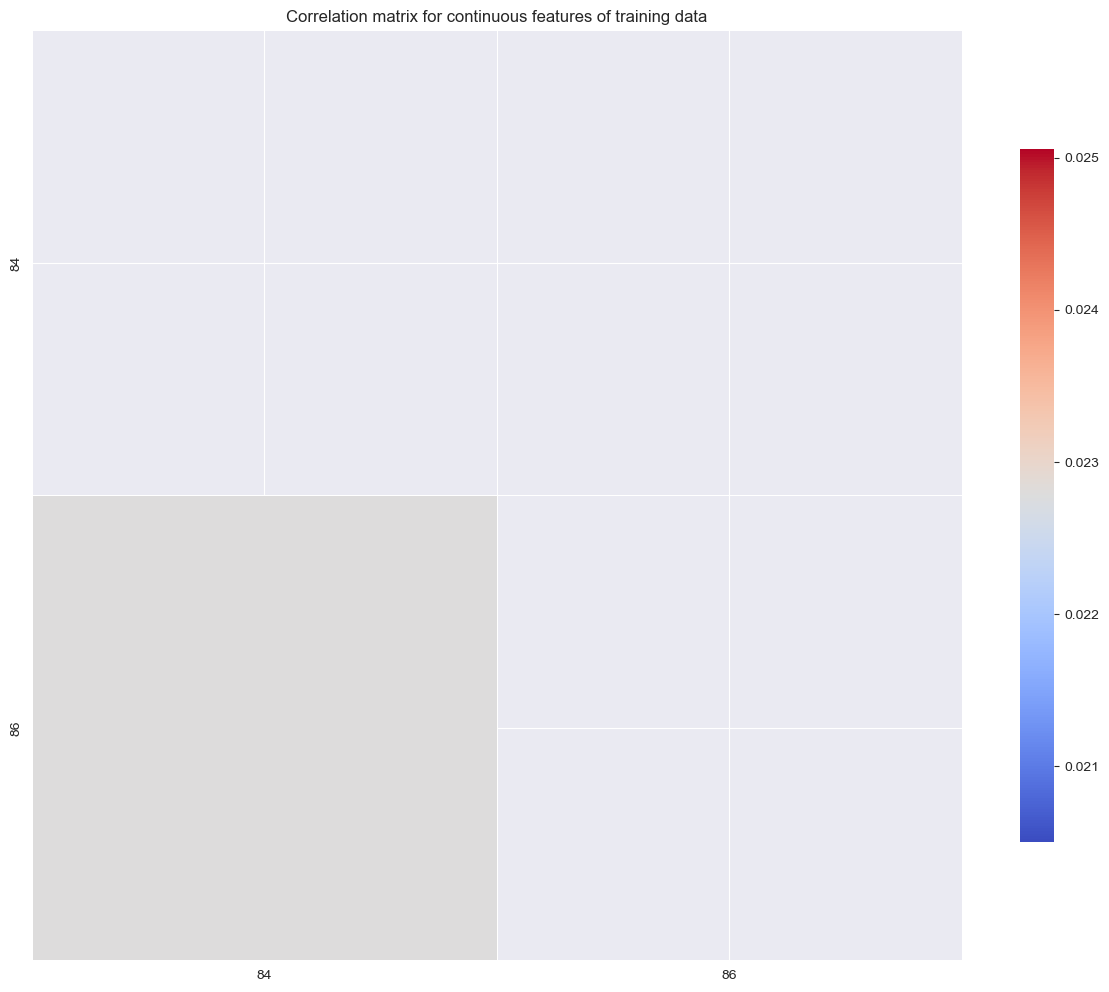

CPU times: total: 188 ms
Wall time: 198 ms


In [15]:
%%time
# get list of columns with high correlations
corr = train[cont_features].corr().abs()
high_corr=np.where(corr>0.02)
high_corr=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr) if x!=y and x<y]
print('initial correlations calculated')
#print("high correlation \n",high_corr)
high_corr_features=[]
for x in high_corr:
    for item in x:
        if item not in high_corr_features:
            high_corr_features.append(item)
corr_matrix = train[high_corr_features].corr()
print('highest correlations calculated')

# create heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
plt.figure(figsize = (15, 15))
plt.title('Correlation matrix for continuous features of training data')
sns.heatmap(corr_matrix, cmap='coolwarm',mask = mask,annot=False, linewidths = .5,square=True,cbar_kws={"shrink": .60})
plt.show()

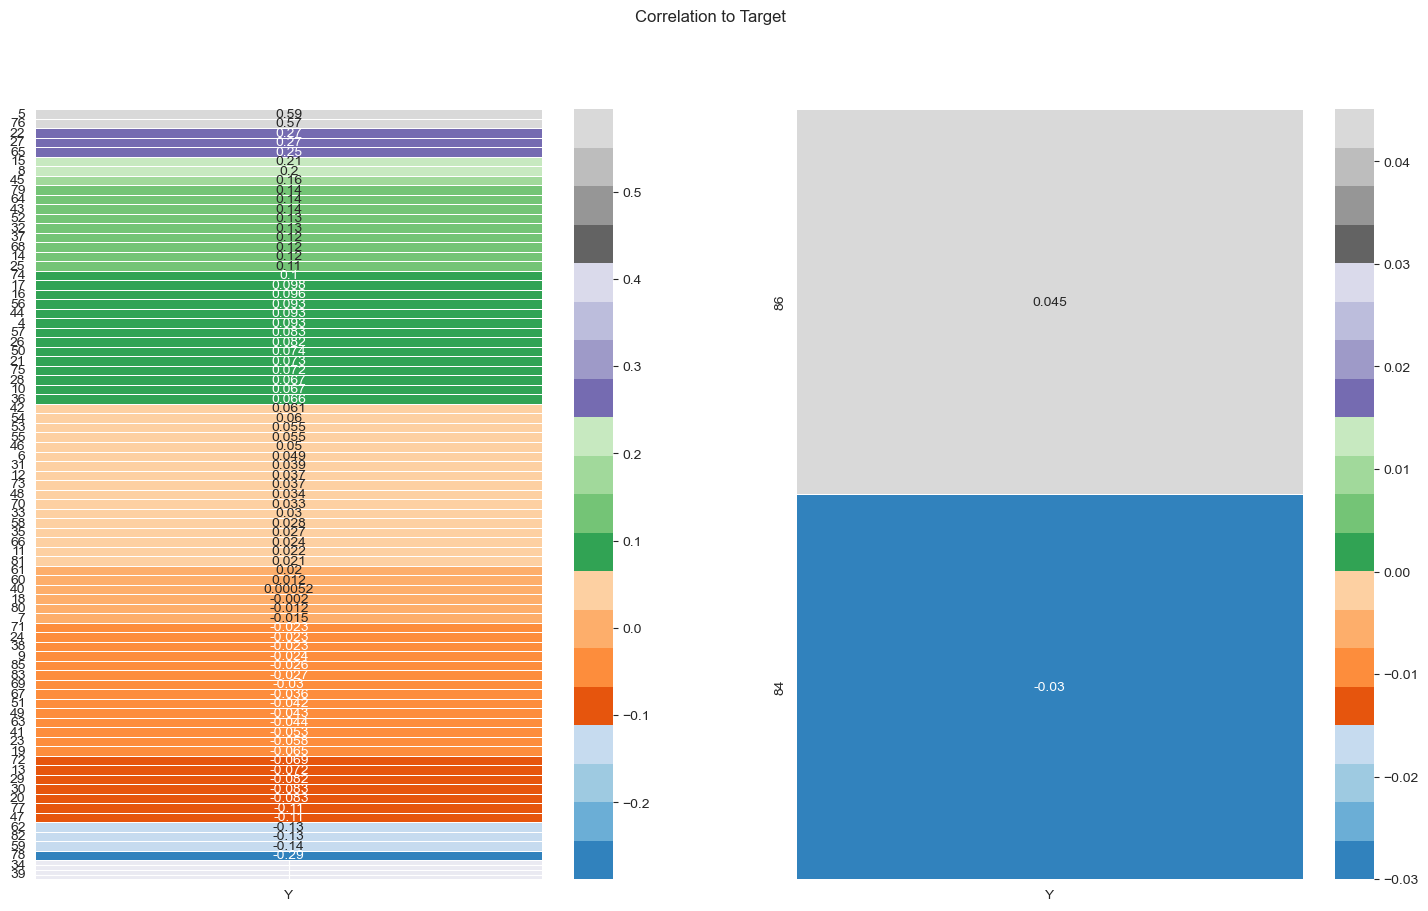

CPU times: total: 2.3 s
Wall time: 817 ms


In [16]:
%%time
# correlations to target
# idea/code taken https://www.kaggle.com/rahullalu/tps-oct-2021-eda-and-baseline

corr_cat=pd.DataFrame()
corr_cat['Y'] = train[cat_features].corrwith(train['Y'])
df_cat=corr_cat.sort_values(by='Y', ascending=False)

corr_cont=pd.DataFrame()
corr_cont['Y'] = train[high_corr_features].corrwith(train['Y'])
df_cont=corr_cont.sort_values(by='Y', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Correlation to Target')

heatmap = sns.heatmap(ax=axes[0],data=df_cat,annot=True,cmap='tab20c',linewidth=0.5,xticklabels=df_cat.columns,yticklabels=df_cat.index)
heatmap = sns.heatmap(ax=axes[1],data=df_cont,annot=True,cmap='tab20c',linewidth=0.5,xticklabels=df_cont.columns,yticklabels=df_cont.index)
plt.show()

corr_cont=pd.DataFrame()
corr_cont['Y'] = train[cont_features].corrwith(train['Y'])
df_cont=corr_cont.sort_values(by='Y', ascending=False)

del df_cont, df_cat, corr_cat, corr_cont

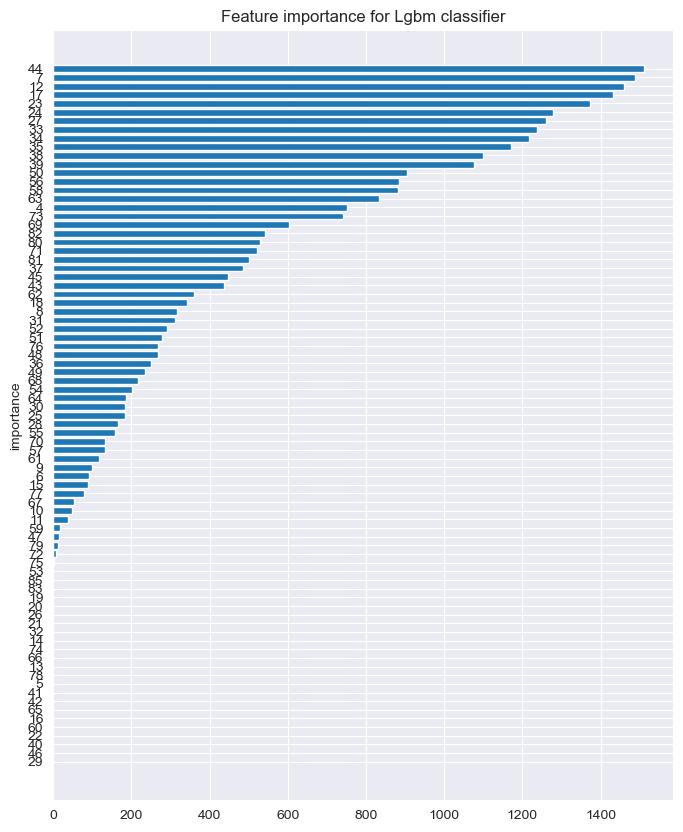

In [17]:
# Feature importance lgbm
X=train[cat_features]
y=train['Y']
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,train_size=0.8,test_size = 0.2,random_state = 0)

# instanciate and fit model
lgbm_checker = LGBMClassifier(learning_rate=0.05,
                              n_estimators=1000,
                              reg_lambda = 1)

lgbm_checker.fit(X_train, y_train)

# put feature impoartance into table
importances_df = pd.DataFrame(lgbm_checker.feature_importances_, columns=['Feature_Importance'],
                              index=X_train.columns)
importances_df.sort_values(by=['Feature_Importance'], ascending=False, inplace=True)
#print(importances_df)

# plot importance as bar chart
importances=importances_df.index
importances_df = importances_df.sort_values(['Feature_Importance'])
y_pos = np.arange(len(importances_df))
plt.figure(figsize=(8,10))
plt.barh(y_pos,importances_df['Feature_Importance'])
plt.yticks(y_pos, importances,fontsize=10)
plt.ylabel('importance')
plt.title('Feature importance for Lgbm classifier')
plt.show()

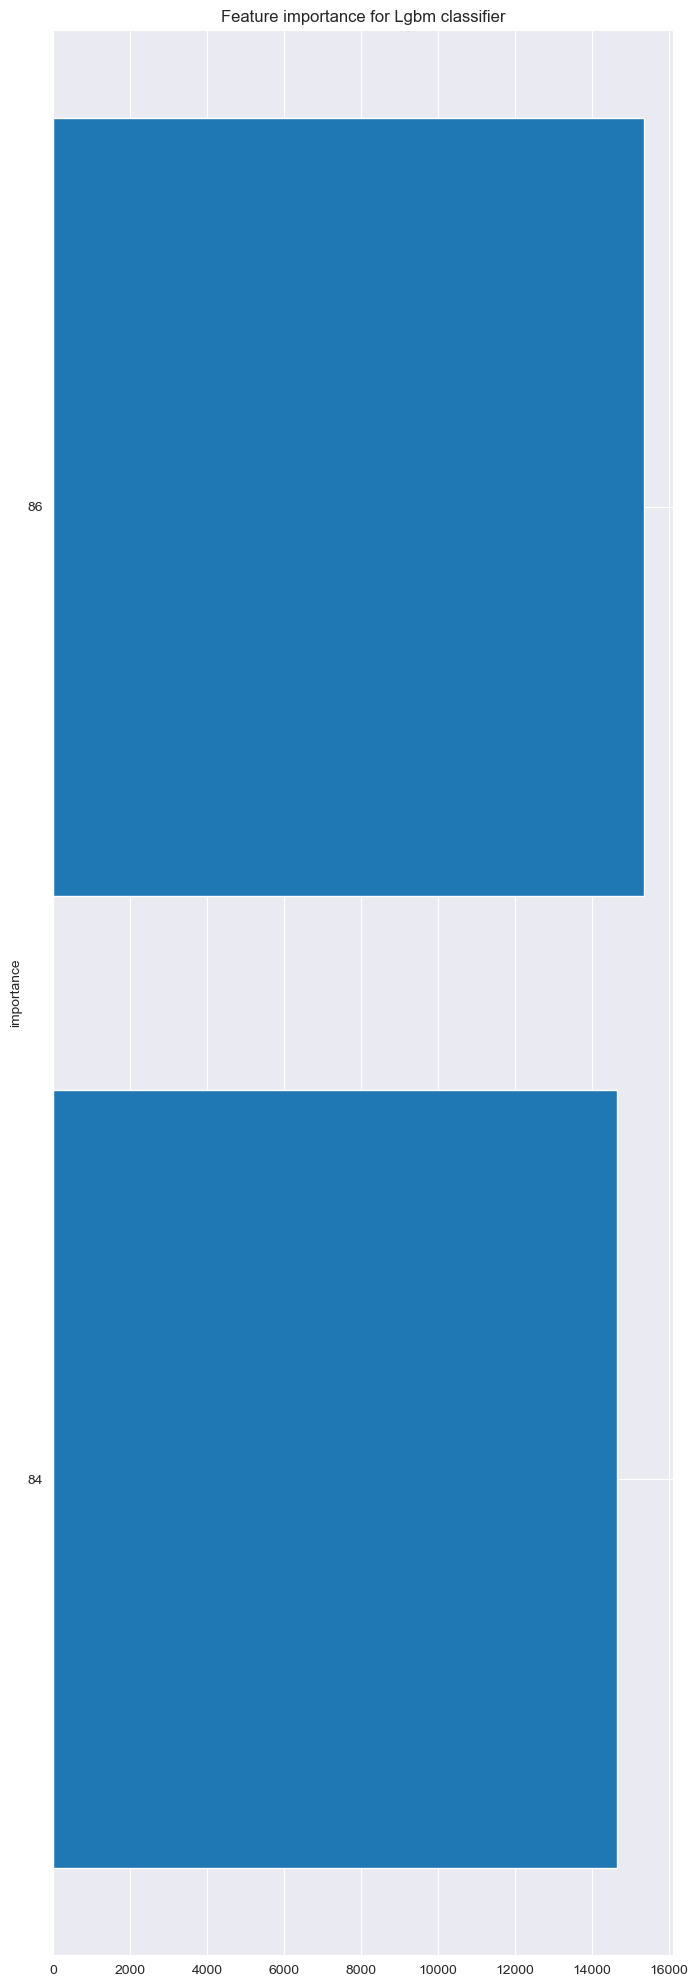

In [18]:
# Feature importance lgbm
X=train[cont_features]
y=train['Y']
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,train_size=0.8,test_size = 0.2,random_state = 0)

# instanciate and fit model
lgbm_checker = LGBMClassifier(learning_rate=0.05,
                              n_estimators=1000,
                              reg_lambda = 1)

lgbm_checker.fit(X_train, y_train)

# put feature impoartance into table
importances_df = pd.DataFrame(lgbm_checker.feature_importances_, columns=['Feature_Importance'],
                              index=X_train.columns)
importances_df.sort_values(by=['Feature_Importance'], ascending=False, inplace=True)
#print(importances_df)

# plot importance as bar chart
importances=importances_df.index
importances_df = importances_df.sort_values(['Feature_Importance'])
y_pos = np.arange(len(importances_df))
plt.figure(figsize=(8,25))
plt.barh(y_pos,importances_df['Feature_Importance'])
plt.yticks(y_pos, importances,fontsize=10)
plt.ylabel('importance')
plt.title('Feature importance for Lgbm classifier')
plt.show()

Number of predictors:  85
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 days 6 hours 2 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 12 days
H2O_cluster_name:,H2O_from_python_bqtx0_r1ydj5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12.00 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


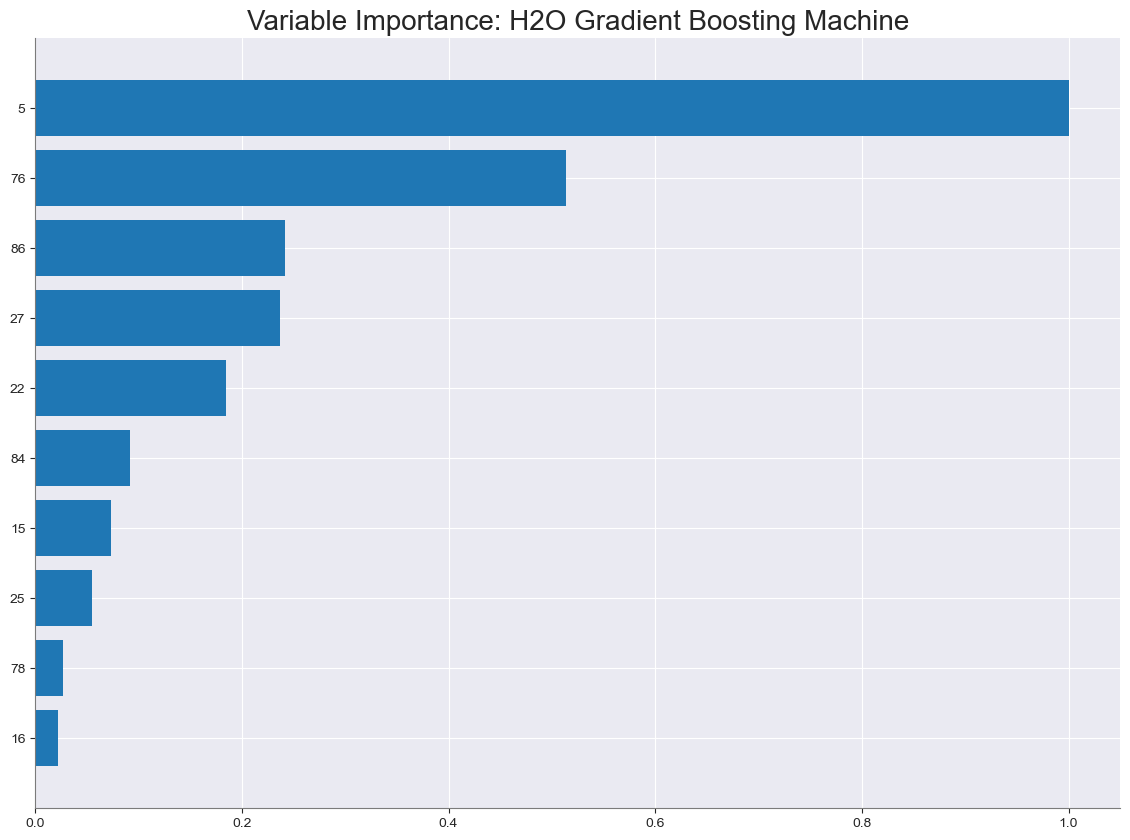

CPU times: total: 828 ms
Wall time: 1min 8s


<Figure size 640x480 with 0 Axes>

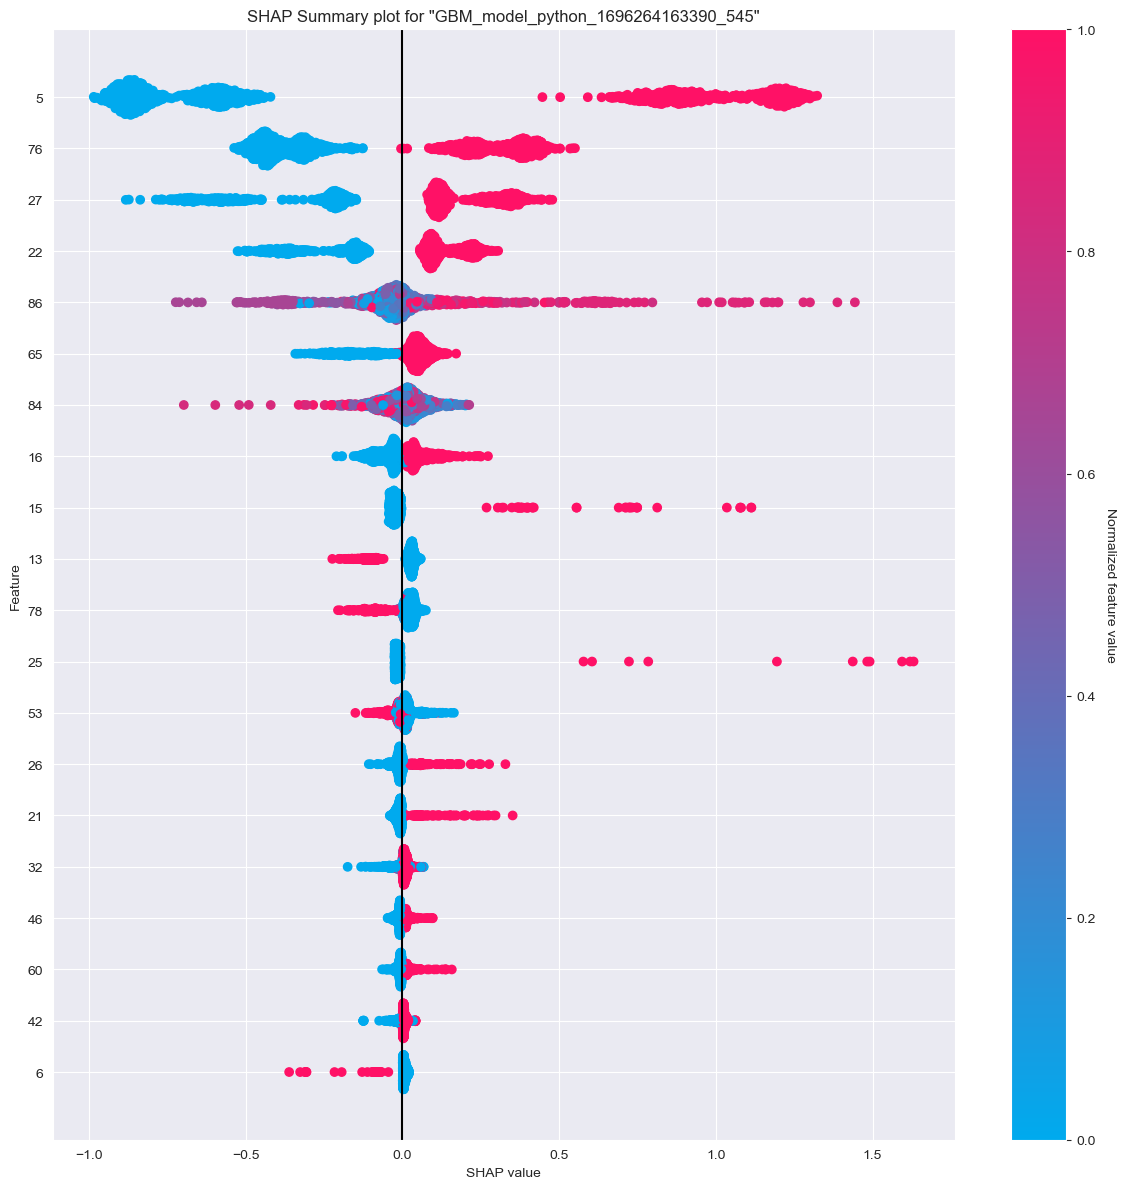

In [19]:
%%time
#taken from https://www.kaggle.com/docxian/tabular-playground-10-first-glance-baseline/notebook#Model 

# extract list of features
features = train.columns.tolist()
features.remove('Id')
features.remove('Y')

# select predictors
predictors = features
print('Number of predictors: ', len(predictors))

# start H2O
h2o.init(max_mem_size='12G', nthreads=4) # define maximum memory usage and number of cores

# upload data in H2O environment
# let's start with a SUBSET of training data only to reduce RAM use!
n_sub = 2853
train_sub = train.sample(n=n_sub, random_state=42)
train_hex = h2o.H2OFrame(train_sub)

# force categorical target
train_hex['Y'] = train_hex['Y'].asfactor()

# fit Gradient Boosting model
n_cv = 5 # 5 folds

fit_GBM = H2OGradientBoostingEstimator(ntrees=250,
                                       max_depth=6,
                                       min_rows=10,
                                       learn_rate=0.1, # default: 0.1
                                       sample_rate=1,
                                       col_sample_rate=0.5,
                                       nfolds=n_cv,
                                       score_each_iteration=True,
                                       stopping_metric='auc',
                                       stopping_rounds=5,
                                       stopping_tolerance=0.0001*0.5,
                                       seed=999)
# train model
fit_GBM.train(x=predictors,
              y='Y',
              training_frame=train_hex)

# variable importance
fit_GBM.varimp_plot()

# alternative variable importance using SHAP => see direction as well as severity of feature impact
fit_GBM.shap_summary_plot(train_hex);

CPU times: total: 250 ms
Wall time: 57 ms


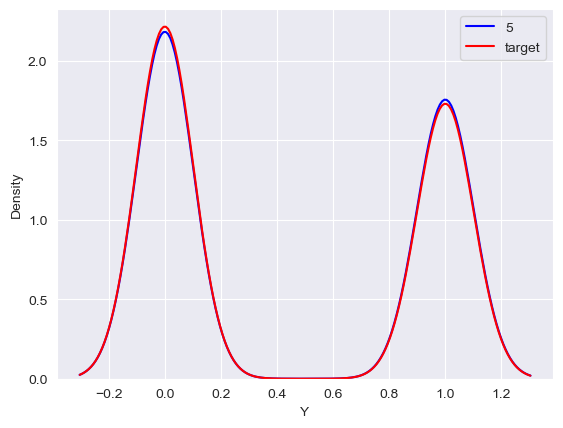

In [20]:
%%time
# feature 'f22' ditribution v's target
sns.distplot(train['5'], kde=True, hist=False, color='blue', label='5')
sns.distplot(train['Y'], kde=True, hist=False, color='red', label='target')
plt.legend()

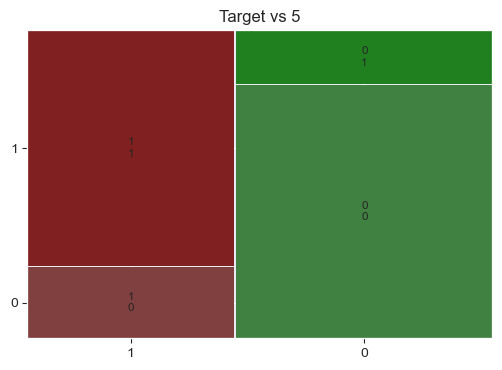

In [21]:
# plot target vs binary features using mosaic plot
# taken from https://www.kaggle.com/docxian/tabular-playground-10-first-glance-baseline/notebook#Model
plt_para_save = plt.rcParams['figure.figsize'] # remember plot settings

for f in ['5']:
    plt.rcParams['figure.figsize'] = (6,4) # increase plot size for mosaics
    mosaic(train, [f, 'Y'], title='Target vs ' + f)
    plt.show()

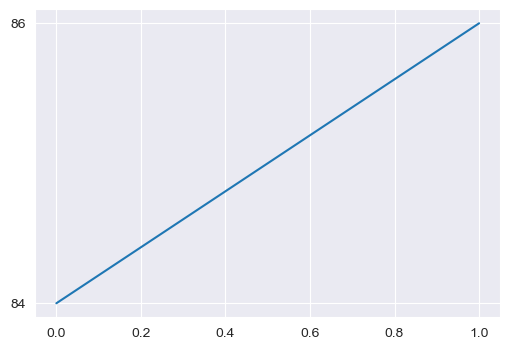

In [22]:
plt.plot()

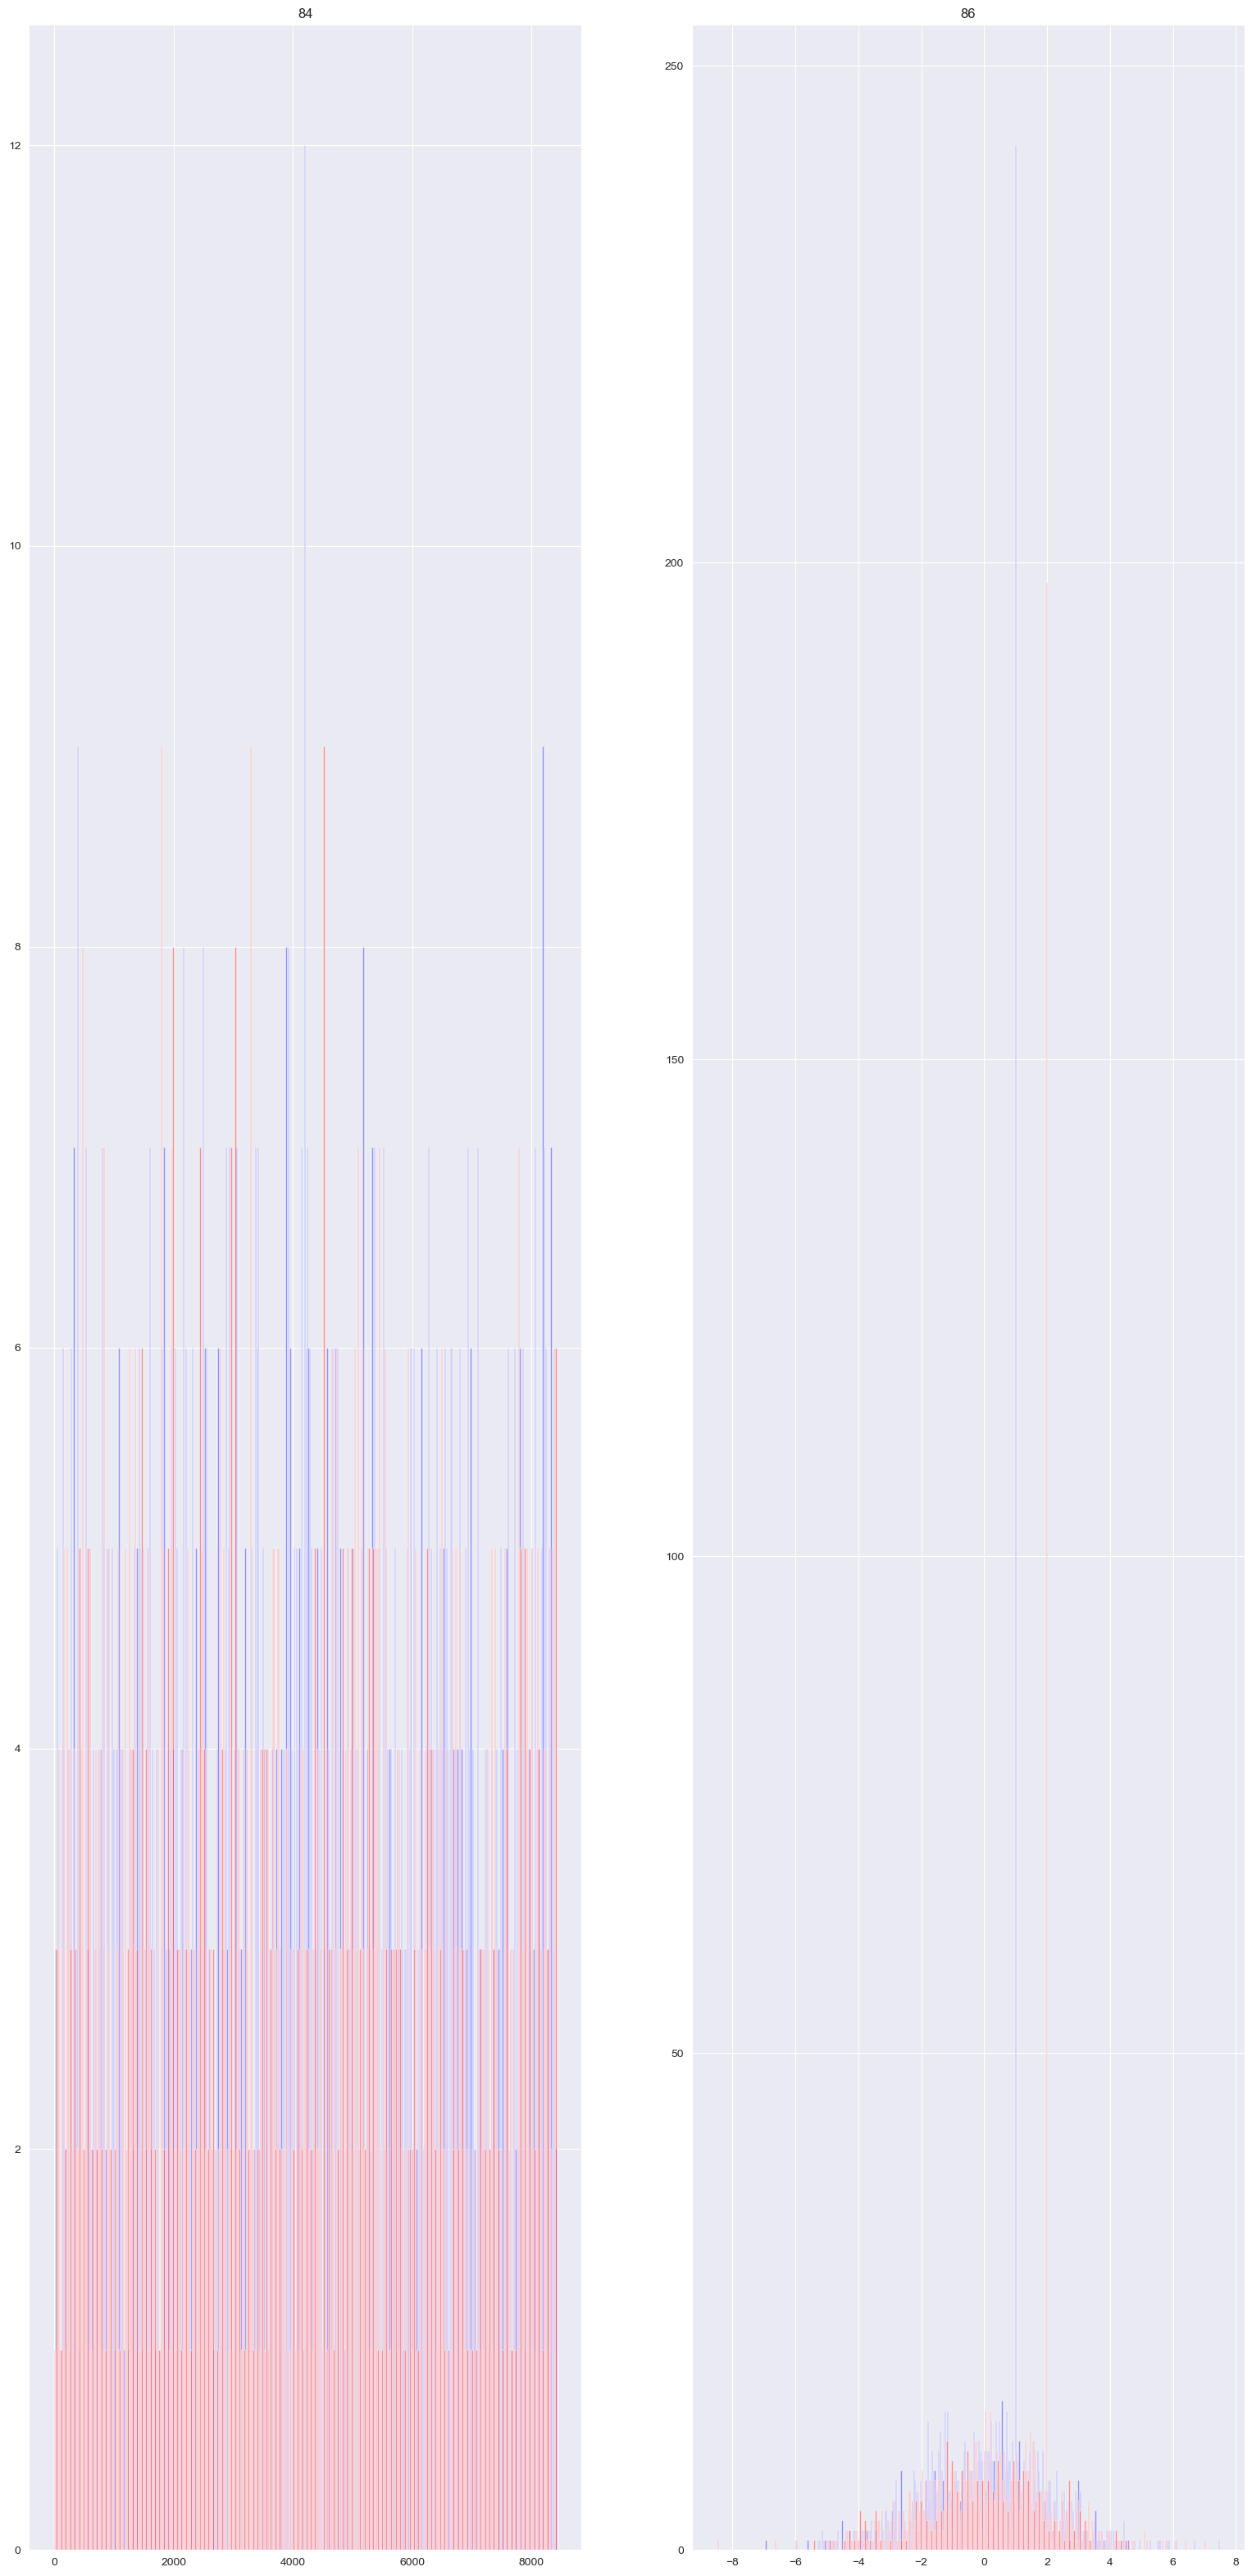

In [24]:
fig = plt.figure(figsize = (40, 40))
for idx, i in enumerate(train_outliers_0.columns):
    fig.add_subplot(int(np.ceil(len(train_outliers_0.columns)/4)), 4, idx+1)
    train_outliers_0.iloc[:, idx].hist(bins=500,color='b',alpha=0.5)
    train_outliers_1.iloc[:, idx].hist(bins = 500,color='r',alpha=0.5)
    plt.subplots_adjust(hspace=0.2)
    plt.title(i)
plt.show()